# Setting up dependencies

1. Pytorch and torchvision
2. Flower dataset
3. Upload `cat_to_name.json`

In [0]:
 # Google Colab -> Install PyTorch
!pip install torch torchvision

# download and unzip dataset
!wget https://s3.amazonaws.com/content.udacity-data.com/courses/nd188/flower_data.zip
!unzip -qq flower_data.zip

In [0]:
from google.colab import files

# Upload cat_to_name.json
uploaded = files.upload()

# Developing an AI application

Going forward, AI algorithms will be incorporated into more and more everyday applications. For example, you might want to include an image classifier in a smart phone app. To do this, you'd use a deep learning model trained on hundreds of thousands of images as part of the overall application architecture. A large part of software development in the future will be using these types of models as common parts of applications. 

In this project, you'll train an image classifier to recognize different species of flowers. You can imagine using something like this in a phone app that tells you the name of the flower your camera is looking at. In practice you'd train this classifier, then export it for use in your application. We'll be using [this dataset](http://www.robots.ox.ac.uk/~vgg/data/flowers/102/index.html) of 102 flower categories, you can see a few examples below. 

<img src='assets/Flowers.png' width=500px>

The project is broken down into multiple steps:

* Load and preprocess the image dataset
* Train the image classifier on your dataset
* Use the trained classifier to predict image content

We'll lead you through each part which you'll implement in Python.

When you've completed this project, you'll have an application that can be trained on any set of labeled images. Here your network will be learning about flowers and end up as a command line application. But, what you do with your new skills depends on your imagination and effort in building a dataset. For example, imagine an app where you take a picture of a car, it tells you what the make and model is, then looks up information about it. Go build your own dataset and make something new.

First up is importing the packages you'll need. It's good practice to keep all the imports at the beginning of your code. As you work through this notebook and find you need to import a package, make sure to add the import up here.

In [0]:
# Imports here

import torch
from torch import nn
import torch.optim as optim
import torch.nn.functional as F

from torch.utils.data.sampler import SubsetRandomSampler
from torchvision import datasets, transforms, models

from collections import OrderedDict

import numpy as np
import matplotlib.pyplot as plt
from PIL import Image
%matplotlib inline


## Load the data

Here you'll use `torchvision` to load the data ([documentation](http://pytorch.org/docs/0.3.0/torchvision/index.html)). You can [download the data here](https://s3.amazonaws.com/content.udacity-data.com/courses/nd188/flower_data.zip). The dataset is split into two parts, training and validation. For the training, you'll want to apply transformations such as random scaling, cropping, and flipping. This will help the network generalize leading to better performance. If you use a pre-trained network, you'll also need to make sure the input data is resized to 224x224 pixels as required by the networks.

The validation set is used to measure the model's performance on data it hasn't seen yet. For this you don't want any scaling or rotation transformations, but you'll need to resize then crop the images to the appropriate size.

The pre-trained networks available from `torchvision` were trained on the ImageNet dataset where each color channel was normalized separately. For both sets you'll need to normalize the means and standard deviations of the images to what the network expects. For the means, it's `[0.485, 0.456, 0.406]` and for the standard deviations `[0.229, 0.224, 0.225]`, calculated from the ImageNet images.  These values will shift each color channel to be centered at 0 and range from -1 to 1.

In [0]:
data_dir = './flower_data'
train_dir = data_dir + '/train/'
valid_dir = data_dir + '/valid/'

In [0]:
# TODO: Define your transforms for the training and validation sets
train_transforms = transforms.Compose([transforms.RandomRotation(30),
                                       transforms.RandomResizedCrop(224),
                                       transforms.RandomHorizontalFlip(),
                                       transforms.ToTensor(),
                                       transforms.Normalize([0.485, 0.456, 0.406],
                                                            [0.229, 0.224, 0.225])])

valid_transforms = transforms.Compose([transforms.Resize(256),
                                      transforms.CenterCrop(224),
                                      transforms.ToTensor(),
                                      transforms.Normalize([0.485, 0.456, 0.406],
                                                           [0.229, 0.224, 0.225])])

# TODO: Load the datasets with ImageFolder
train_data = datasets.ImageFolder(train_dir, transform=train_transforms)
valid_data = datasets.ImageFolder(valid_dir, transform=valid_transforms)

# TODO: Using the image datasets and the trainforms, define the dataloaders
train_loader = torch.utils.data.DataLoader(train_data, batch_size=64, shuffle=True)
valid_loader = torch.utils.data.DataLoader(valid_data, batch_size=64, shuffle=True)

### Label mapping

You'll also need to load in a mapping from category label to category name. You can find this in the file `cat_to_name.json`. It's a JSON object which you can read in with the [`json` module](https://docs.python.org/2/library/json.html). This will give you a dictionary mapping the integer encoded categories to the actual names of the flowers.

In [0]:
import json

with open('cat_to_name.json', 'r') as f:
    cat_to_name = json.load(f)

# Building and training the classifier

Now that the data is ready, it's time to build and train the classifier. As usual, you should use one of the pretrained models from `torchvision.models` to get the image features. Build and train a new feed-forward classifier using those features.

We're going to leave this part up to you. If you want to talk through it with someone, chat with your fellow students! You can also ask questions on the forums or join the instructors in office hours.

Refer to [the rubric](https://review.udacity.com/#!/rubrics/1663/view) for guidance on successfully completing this section. Things you'll need to do:

* Load a [pre-trained network](http://pytorch.org/docs/master/torchvision/models.html) (If you need a starting point, the VGG networks work great and are straightforward to use)
* Define a new, untrained feed-forward network as a classifier, using ReLU activations and dropout
* Train the classifier layers using backpropagation using the pre-trained network to get the features
* Track the loss and accuracy on the validation set to determine the best hyperparameters

We've left a cell open for you below, but use as many as you need. Our advice is to break the problem up into smaller parts you can run separately. Check that each part is doing what you expect, then move on to the next. You'll likely find that as you work through each part, you'll need to go back and modify your previous code. This is totally normal!

When training make sure you're updating only the weights of the feed-forward network. You should be able to get the validation accuracy above 70% if you build everything right. Make sure to try different hyperparameters (learning rate, units in the classifier, epochs, etc) to find the best model. Save those hyperparameters to use as default values in the next part of the project.

In [5]:
# TODO: Build and train your network

flatten_layers = {"vgg16":25088,
                  "densenet121":1024}

def get_model(name="vgg16", classifier=None, drop_prob=0.5):
  """Get pre trained model and stack fully connected layers
  
  Arguments
  ---------
  name -> pre trained model name (vgg16 or densenet121)
  classifier -> nn.Sequencial classifier. If None, a default classifier will be set in place.
  drop_prob -> dropout value
  """
  
  # load pre trained model
  if name == "vgg16":
    model = models.vgg16(pretrained=True)
  elif name == "densenet121":
    model = models.densenet121(pretrained=True)
  else:
    print("Model not available at the moment.")
    
  # freeze parameters so we don't backprop through them
  for param in model.parameters():
    param.requires_grad = False
    
  # build classifier layers
  if classifier is None:
    classifier = nn.Sequential(OrderedDict([
                            ('fc1', nn.Linear(flatten_layers[name], 1024)),
                            ('relu1', nn.ReLU()),
                            ('drop1', nn.Dropout(drop_prob)),
                            ('fc2', nn.Linear(1024, 512)),
                            ('relu2', nn.ReLU()),
                            ('drop2', nn.Dropout(drop_prob)),
                            ('fc3', nn.Linear(512, 102)),
                            ('output', nn.LogSoftmax(dim=1))
                            ]))
  
  # add classifier to model
  model.classifier = classifier
  # model to gpu
  model.cuda()
  
  return model  

model = get_model("densenet121")
print(model)

/usr/local/lib/python3.6/dist-packages/torchvision/models/densenet.py:212: UserWarning: nn.init.kaiming_normal is now deprecated in favor of nn.init.kaiming_normal_.
  nn.init.kaiming_normal(m.weight.data)


DenseNet(
  (features): Sequential(
    (conv0): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (norm0): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu0): ReLU(inplace)
    (pool0): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (denseblock1): _DenseBlock(
      (denselayer1): _DenseLayer(
        (norm1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu1): ReLU(inplace)
        (conv1): Conv2d(64, 128, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (norm2): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu2): ReLU(inplace)
        (conv2): Conv2d(128, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      )
      (denselayer2): _DenseLayer(
        (norm1): BatchNorm2d(96, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu1): ReLU(inplac

In [11]:
# Putting the above into functions, so they can be used later
vloader = valid_loader
trainloader = train_loader
criterion = nn.NLLLoss()
optimizer = optim.Adam(model.classifier.parameters(), lr=5e-3)
  
  
epochs = 12
print_every = 5
steps = 0
loss_show=[]

# change to cuda
model.to('cuda')

for e in range(epochs):
    running_loss = 0
    for ii, (inputs, labels) in enumerate(trainloader):
        steps += 1
        
        inputs,labels = inputs.to('cuda'), labels.to('cuda')
        
        optimizer.zero_grad()
        
        # Forward and backward passes
        outputs = model.forward(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        
        running_loss += loss.item()
        
        if steps % print_every == 0:
            model.eval()
            vlost = 0
            accuracy=0
            
            
            for ii, (inputs2,labels2) in enumerate(vloader):
                optimizer.zero_grad()
                
                inputs2, labels2 = inputs2.to('cuda:0') , labels2.to('cuda:0')
                model.to('cuda:0')
                with torch.no_grad():    
                    outputs = model.forward(inputs2)
                    vlost = criterion(outputs,labels2)
                    ps = torch.exp(outputs).data
                    equality = (labels2.data == ps.max(1)[1])
                    accuracy += equality.type_as(torch.FloatTensor()).mean()
                    
            vlost = vlost / len(vloader)
            accuracy = accuracy /len(vloader)
            
                    
            
            print("Epoch: {}/{}... ".format(e+1, epochs),
                  "Loss: {:.4f}".format(running_loss/print_every),
                  "Validation Lost {:.4f}".format(vlost),
                   "Accuracy: {:.4f}".format(accuracy))
            
            
            running_loss = 0

Epoch: 1/12...  Loss: 2.3396 Validation Lost 0.1629 Accuracy: 0.4571
Epoch: 1/12...  Loss: 2.0389 Validation Lost 0.1697 Accuracy: 0.4552
Epoch: 1/12...  Loss: 1.8727 Validation Lost 0.1288 Accuracy: 0.5403
Epoch: 1/12...  Loss: 1.8431 Validation Lost 0.1373 Accuracy: 0.5525
Epoch: 1/12...  Loss: 1.8662 Validation Lost 0.1167 Accuracy: 0.5740
Epoch: 1/12...  Loss: 1.6377 Validation Lost 0.1280 Accuracy: 0.5891
Epoch: 1/12...  Loss: 1.5410 Validation Lost 0.1148 Accuracy: 0.6269
Epoch: 1/12...  Loss: 1.4106 Validation Lost 0.0707 Accuracy: 0.6562
Epoch: 1/12...  Loss: 1.4136 Validation Lost 0.0905 Accuracy: 0.6710
Epoch: 1/12...  Loss: 1.3973 Validation Lost 0.0819 Accuracy: 0.6783
Epoch: 1/12...  Loss: 1.3493 Validation Lost 0.0634 Accuracy: 0.6835
Epoch: 1/12...  Loss: 1.2981 Validation Lost 0.0963 Accuracy: 0.6615
Epoch: 1/12...  Loss: 1.5492 Validation Lost 0.1012 Accuracy: 0.6466
Epoch: 1/12...  Loss: 1.4243 Validation Lost 0.0588 Accuracy: 0.6838
Epoch: 1/12...  Loss: 1.2527 Valid

## Save the checkpoint

Now that your network is trained, save the model so you can load it later for making predictions. You probably want to save other things such as the mapping of classes to indices which you get from one of the image datasets: `image_datasets['train'].class_to_idx`. You can attach this to the model as an attribute which makes inference easier later on.

```model.class_to_idx = image_datasets['train'].class_to_idx```

Remember that you'll want to completely rebuild the model later so you can use it for inference. Make sure to include any information you need in the checkpoint. If you want to load the model and keep training, you'll want to save the number of epochs as well as the optimizer state, `optimizer.state_dict`. You'll likely want to use this trained model in the next part of the project, so best to save it now.

In [0]:
# TODO: Save the checkpoint 
model.class_to_idx = train_data.class_to_idx

checkpoint = {"name":"densenet121",
              "classifier":None,
              "drop_prob":0.5,
              "state_dict":model.state_dict(),
              "class_to_idx":model.class_to_idx}

with open("final_project_densenet121.pth", "wb") as f:
  torch.save(checkpoint, f)

## Loading the checkpoint

At this point it's good to write a function that can load a checkpoint and rebuild the model. That way you can come back to this project and keep working on it without having to retrain the network.

In [70]:
# TODO: Write a function that loads a checkpoint and rebuilds the model
def load_model(path):
  """Load checkpoints model from path"""
  
  checkpoint = torch.load(path)
  
  name = checkpoint["name"]
  classifier = checkpoint["classifier"]
  drop_prob = checkpoint["drop_prob"]
  
  model = get_model(name, classifier, drop_prob)
  model.class_to_idx = checkpoint['class_to_idx']
  model.load_state_dict(checkpoint['state_dict'])
  model.eval()
  
  return model
  
model2 = load_model("final_project_densenet121.pth")
# print(model2)

/usr/local/lib/python3.6/dist-packages/torchvision/models/densenet.py:212: UserWarning: nn.init.kaiming_normal is now deprecated in favor of nn.init.kaiming_normal_.
  nn.init.kaiming_normal(m.weight.data)


# Inference for classification

Now you'll write a function to use a trained network for inference. That is, you'll pass an image into the network and predict the class of the flower in the image. Write a function called `predict` that takes an image and a model, then returns the top $K$ most likely classes along with the probabilities. It should look like 

```python
probs, classes = predict(image_path, model)
print(probs)
print(classes)
> [ 0.01558163  0.01541934  0.01452626  0.01443549  0.01407339]
> ['70', '3', '45', '62', '55']
```

First you'll need to handle processing the input image such that it can be used in your network. 

## Image Preprocessing

You'll want to use `PIL` to load the image ([documentation](https://pillow.readthedocs.io/en/latest/reference/Image.html)). It's best to write a function that preprocesses the image so it can be used as input for the model. This function should process the images in the same manner used for training. 

First, resize the images where the shortest side is 256 pixels, keeping the aspect ratio. This can be done with the [`thumbnail`](http://pillow.readthedocs.io/en/3.1.x/reference/Image.html#PIL.Image.Image.thumbnail) or [`resize`](http://pillow.readthedocs.io/en/3.1.x/reference/Image.html#PIL.Image.Image.thumbnail) methods. Then you'll need to crop out the center 224x224 portion of the image.

Color channels of images are typically encoded as integers 0-255, but the model expected floats 0-1. You'll need to convert the values. It's easiest with a Numpy array, which you can get from a PIL image like so `np_image = np.array(pil_image)`.

As before, the network expects the images to be normalized in a specific way. For the means, it's `[0.485, 0.456, 0.406]` and for the standard deviations `[0.229, 0.224, 0.225]`. You'll want to subtract the means from each color channel, then divide by the standard deviation. 

And finally, PyTorch expects the color channel to be the first dimension but it's the third dimension in the PIL image and Numpy array. You can reorder dimensions using [`ndarray.transpose`](https://docs.scipy.org/doc/numpy-1.13.0/reference/generated/numpy.ndarray.transpose.html). The color channel needs to be first and retain the order of the other two dimensions.

In [0]:
def process_image(image):
    ''' Scales, crops, and normalizes a PIL image for a PyTorch model,
        returns an Numpy array
    '''
    
    # TODO: Process a PIL image for use in a PyTorch model
    img = Image.open(image)
    
    transformations = transforms.Compose([transforms.Resize(256),
                                      transforms.CenterCrop(224),
                                      transforms.ToTensor(),
                                      transforms.Normalize([0.485, 0.456, 0.406],
                                                           [0.229, 0.224, 0.225])])
    
    img_tensor = transformations(img)
    
    return img_tensor

To check your work, the function below converts a PyTorch tensor and displays it in the notebook. If your `process_image` function works, running the output through this function should return the original image (except for the cropped out portions).

In [0]:
def imshow(image, ax=None, title=None):
    """Imshow for Tensor."""
    if ax is None:
        fig, ax = plt.subplots()
    
    # PyTorch tensors assume the color channel is the first dimension
    # but matplotlib assumes is the third dimension
    image = image.numpy().transpose((1, 2, 0))
    
    # Undo preprocessing
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    image = std * image + mean
    
    # Image needs to be clipped between 0 and 1 or it looks like noise when displayed
    image = np.clip(image, 0, 1)
    
    ax.imshow(image)
    
    return ax

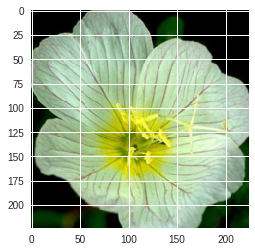

In [22]:
# test funcions above
image_path = "./flower_data/valid/1/image_06739.jpg"
imshow(process_image(image_path))

## Class Prediction

Once you can get images in the correct format, it's time to write a function for making predictions with your model. A common practice is to predict the top 5 or so (usually called top-$K$) most probable classes. You'll want to calculate the class probabilities then find the $K$ largest values.

To get the top $K$ largest values in a tensor use [`x.topk(k)`](http://pytorch.org/docs/master/torch.html#torch.topk). This method returns both the highest `k` probabilities and the indices of those probabilities corresponding to the classes. You need to convert from these indices to the actual class labels using `class_to_idx` which hopefully you added to the model or from an `ImageFolder` you used to load the data ([see here](#Save-the-checkpoint)). Make sure to invert the dictionary so you get a mapping from index to class as well.

Again, this method should take a path to an image and a model checkpoint, then return the probabilities and classes.

```python
probs, classes = predict(image_path, model)
print(probs)
print(classes)
> [ 0.01558163  0.01541934  0.01452626  0.01443549  0.01407339]
> ['70', '3', '45', '62', '55']
```

In [72]:
def predict(image_path, model, topk=5):
    ''' Predict the class (or classes) of an image using a trained deep learning model.
    '''
    
    # TODO: Implement the code to predict the class from an image file
    model.cuda()
    img_tensor = process_image(image_path)
    img_tensor = img_tensor.unsqueeze_(0)
    
    with torch.no_grad():
      output = model.forward(img_tensor.cuda())
      
    probs = F.softmax(output.data, dim=1)
    
    return probs.topk(topk)
  
# trained model
probs, classes = predict(image_path, model)
print(probs)
print(classes)

# loaded model
probs, classes = predict(image_path, model2)
print(probs)
print(classes)

tensor([[9.9223e-01, 3.2283e-03, 1.8442e-03, 8.3853e-04, 6.5352e-04]],
       device='cuda:0')
tensor([[ 0, 90, 99, 45, 13]], device='cuda:0')
tensor([[9.9223e-01, 3.2283e-03, 1.8442e-03, 8.3853e-04, 6.5352e-04]],
       device='cuda:0')
tensor([[ 0, 90, 99, 45, 13]], device='cuda:0')


## Sanity Checking

Now that you can use a trained model for predictions, check to make sure it makes sense. Even if the validation accuracy is high, it's always good to check that there aren't obvious bugs. Use `matplotlib` to plot the probabilities for the top 5 classes as a bar graph, along with the input image. It should look like this:

<img src='assets/inference_example.png' width=300px>

You can convert from the class integer encoding to actual flower names with the `cat_to_name.json` file (should have been loaded earlier in the notebook). To show a PyTorch tensor as an image, use the `imshow` function defined above.

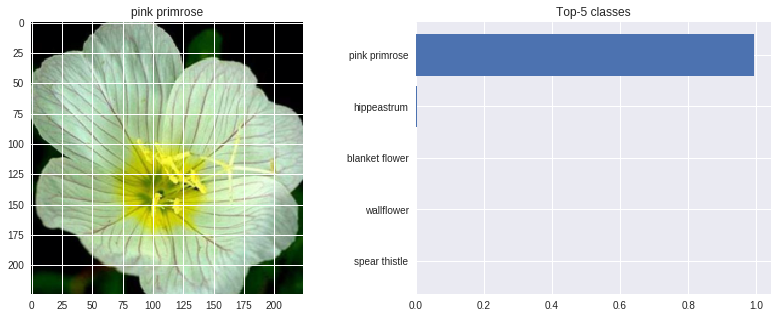

In [136]:
# TODO: Display an image along with the top 5 classes
def sanity_checking(image_path, model, ground_truth, topk=5):
  """Sanity checking function"""
  
  # predict topk classes
  probs, classes = predict(image_path, model, topk)
  probs_list = probs[0].tolist()
  classes_list = [cat_to_name[str(ii+1)] for ii in classes[0].tolist()]
  y_pos = np.arange(len(classes_list))
  
  plt.rcParams["figure.figsize"] = (14,5)
  fig, (ax1, ax2) = plt.subplots(1, 2)
  
  imshow(process_image(image_path), ax=ax1)
  ax1.set_title(cat_to_name[str(ground_truth)])
  
  ax2.barh(y=y_pos, width=probs_list)
  ax2.set_yticks(y_pos)
  ax2.set_yticklabels(classes_list)
  ax2.invert_yaxis()
  ax2.set_title("Top-{} classes".format(topk))

  plt.show()


sanity_checking(image_path, model2, 1) 

## Download model from colab

In [0]:
from google.colab import files
files.download("final_project_densenet121.pth")